## 锚框
每个锚框是一个训练样本,将每个锚框要么标注成背景,要么关联上一个真实边缘框,我们可能会生成大量的锚框,这个导致大量的负类样本

In [10]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)#精简输出精度

In [11]:
#指定输入图像,尺寸列表和宽高比列表,然后此函数将返回所有的锚框
def multibox_prior(data,sizes,ratios):
    """生成以每个像素为中心的锚框，并调整其尺寸和比例"""
    in_height,in_width=data.shape[-2:]
    device,num_sizes,num_ratios=data.device,len(sizes),len(ratios)
    boxes_per_pixel=(num_sizes+num_ratios-1)
    size_tensor=torch.tensor(sizes,device=device)#缩放比
    ratio_tensor=torch.tensor(ratios,device=device)#宽高比

    #为了将锚点移动到像素的中心,需要设置偏移量
    #因为一个像素的的高和宽是1,所以高和宽上的偏移是0.5
    offset_h,offset_w=0.5,0.5
    #在y轴上缩放
    steps_h=1.0/in_height#步长
    steps_w=1.0/in_width#步长
    
    #生成锚框的所有中心点
    center_h=(torch.arange(in_height,device=device)+offset_h)*steps_h#中心点
    center_w=(torch.arange(in_width,device=device)+offset_w)*steps_w#中心点
    shift_y,shift_x=torch.meshgrid(center_h,center_w,indexing='ij')#中心点
    shift_y,shift_x=shift_y.reshape(-1),shift_x.reshape(-1)#中心点

    #生成"boxes_per_pixel"个高和宽
    #之后用于创建锚框的四角坐标(xmin,ymin,xmax,ymax)
    w=torch.cat((size_tensor*torch.sqrt(ratio_tensor[0]),
                 sizes[0]*torch.sqrt(ratio_tensor[1:])))*in_height/in_width
    h=torch.cat((size_tensor/torch.sqrt(ratio_tensor[0]),
                 sizes[0]/torch.sqrt(ratio_tensor[1:])))
    
    #除以2来获得半高和半宽
    anchor_manipulations=torch.stack((-w, -h, w, h)).T.repeat(in_height*in_width,1)/2

    #每个中心点都将有"boxes_per_pixel"个锚框
    out_grid=torch.stack([shift_x,shift_y,shift_x,shift_y],dim=1).repeat_interleave(boxes_per_pixel,dim=0)
    output=out_grid+anchor_manipulations

    return output.unsqueeze(0)




In [13]:
img=d2l.plt.imread('./dogcat.png')
h,w=img.shape[:2]
print(h,w)
X=torch.rand(size=(1,3,h,w))
Y=multibox_prior(X,sizes=[0.75,0.5,0.25],ratios=[1,2,0.5])
Y.shape


346 449


torch.Size([1, 776770, 4])

In [15]:
boxes=Y.reshape(h,w,5,4)
boxes[250,250,0,:]

tensor([0.27, 0.35, 0.85, 1.10])

In [17]:
def show_bboxes(axes,bboxes,labels=None,colors=None):
    """显示所有的边界框"""
    def _make_list(obj,default_values=None):
        if obj is None:
            obj=default_values
        elif not isinstance(obj,(list,tuple)):
            obj=[obj]
        return obj

    labels=_make_list(labels)
    colors=_make_list(colors,['b','g','r','m','k'])
    for i,bbox in enumerate(bboxes):
        color=colors[i%len(colors)]
        rect=d2l.bbox_to_rect(bbox.detach().numpy(),color)
        axes.add_patch(rect)
        if labels and len(labels)>i:
            text_color='k' if color=='w' else 'w'
            axes.text(rect.xy[0],rect.xy[1],labels[i],
                    va='center',ha='center',
                    fontsize=9,color=text_color,
                    bbox={'facecolor':color,'lw':0})

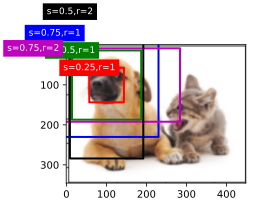

In [19]:
d2l.set_figsize()
bbox_scale=torch.tensor((w,h,w,h))
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,boxes[100,100,:,:]*bbox_scale,
            ['s=0.75,r=1','s=0.5,r=1','s=0.25,r=1','s=0.75,r=2','s=0.5,r=2','s=0.25,r=2']
            )

### 交并比(IoU)
接下来使用交并比来衡量锚框和真实边界框之间的,以及不同锚框之间的相似度,给定两个锚框或边界框的列表,计算他们成对的交并比

In [20]:
def box_iou(boxes1,boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:,2]-boxes[:,0]) *
                              (boxes[:,3]-boxes[:,1]))
    areas1 = box_area(boxes1)
    areas2=box_area(boxes2)
    inter_upperlefts=torch.max(boxes1[:,None,:2],boxes2[:,:2])
    inter_lowerrights=torch.min(boxes1[:,None,2:],boxes2[:,2:])
    inters=(inter_lowerrights-inter_upperlefts).clamp(min=0)

    inter_areas=inters[:,:,0]*inters[:,:,1]
    union_areas=areas1[:,None]+areas2-inter_areas
    return inter_areas/(union_areas+epsilon)


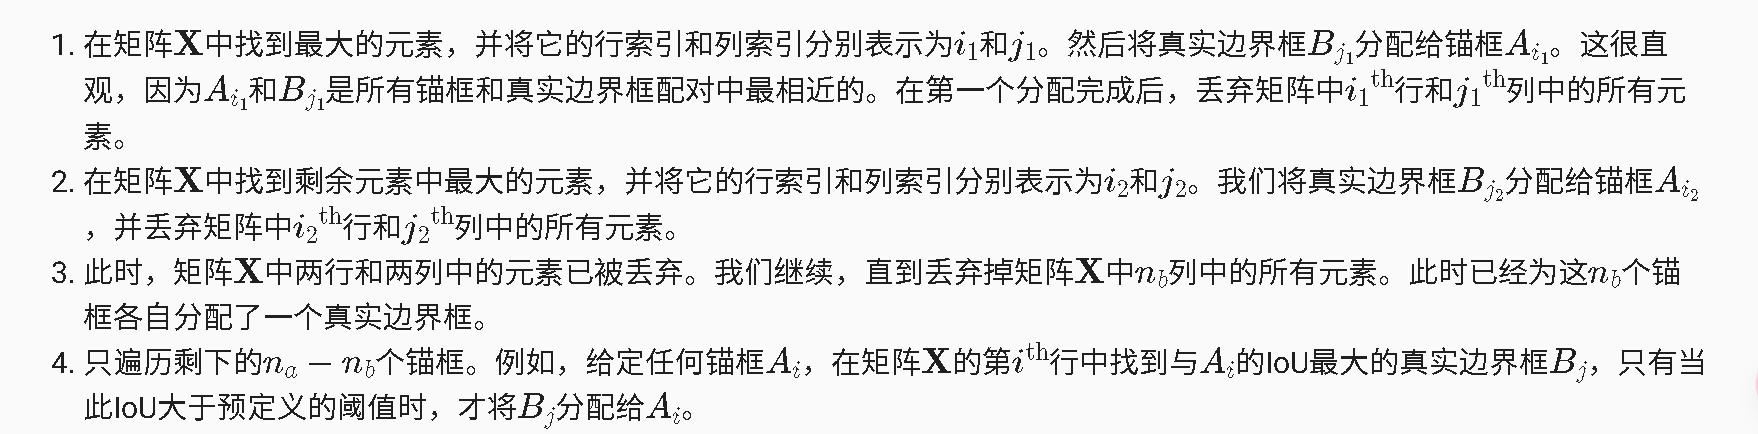

In [24]:
def assign_anchor_to_bbox(ground_truth,anchors,device,iou__threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors,num_gt_boxes=anchors.shape[0],ground_truth.shape[0]
    #位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard=box_iou(anchors,ground_truth)
    #对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map=torch.full((num_anchors,),-1,dtype=torch.long,device=device)
    
    #根据阈值,决定是否分配真实边界框
    max_ious,indices=jaccard.max(dim=1)
    anc_i=torch.nonzero(max_ious>=threshold).reshape(-1)
    box_j=indices[max_ious>=threshold]
    anchors_bbox_map[anc_i]=box_j
    col_discard=torch.full((num_anchors,),-1)
    row_discard=torch.full((num_gt_boxes,),-1)

    for _ in range(num_gt_boxes):
        max_idx=torch.argmax(jaccard)
        box_idx=(max_idx%num_gt_boxes).long()
        anc_idx=(max_idx/num_gt_boxes).long()
        anchors_bbox_map[anc_idx]=box_idx
        jaccard[:,box_idx]=col_discard
        jaccard[anc_idx,:]=row_discard
    return anchors_bbox_map
